In [162]:

import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
import pickle

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import nltk

In [163]:
# download assets
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/akeon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/akeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/akeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/akeon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [164]:
import json
from collections import defaultdict

# path dataset
file_path = "dataset/training_dataset.json"

with open(file_path, "r", encoding="utf-8") as file:
    dataset = json.load(file)

total_context = len(dataset)

total_question_posibility = sum(len(entry["question_posibility"]) for entry in dataset)

question_type_counts = defaultdict(int)
for entry in dataset:
    for question in entry["question_posibility"]:
        question_type_counts[question["type"]] += 1

print(f"Total Context: {total_context}")
print(f"Total Possibility Questions: {total_question_posibility}")
print(f"Total Fill in the Blank Questions: {question_type_counts.get('fill_in_the_blank', 0)}")
print(f"Total Multiple Choice Questions: {question_type_counts.get('multiple_choice', 0)}")
print(f"Total True/False Questions: {question_type_counts.get('true_false', 0)}")


Total Context: 54
Total Possibility Questions: 97
Total Fill in the Blank Questions: 24
Total Multiple Choice Questions: 29
Total True/False Questions: 44


In [ ]:
# Text Preprocessing
stop_words = set(stopwords.words("indonesian"))                                                                                                                                                                                                                                                                             
factory = StemmerFactory()
stemmer = factory.create_stemmer()

with open("normalize_text/normalize.json", "r", encoding="utf-8") as file:
    normalization_dict = json.load(file)


def text_preprocessing(text):
    #doing lower case 
    text = text.lower()
    
    # remove symbol and read mark
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # remove blank space
    text = re.sub(r"\s+", " ", text).strip()
    
    # word tokenize 
    tokens = word_tokenize(text)
    
    
    # normalassi kata
    tokens = [normalization_dict[word] if word in normalization_dict else word for word in tokens] 
    
    
    # Lemmatization using Sastrawi (stemming in Indonesian)
    tokens = [stemmer.stem(word) for word in tokens]
    
    # stopword removal
    tokens = [word for word in tokens if word not in stop_words]  
    
    return tokens

# text processing all data training
contexts = []
questions = []
correct_answers = []
wrong_answers = []
question_types = []

for entry in dataset:
    processed_context = text_preprocessing(entry["context"])
    
    for qa in entry["question_posibility"]:
        processed_question = text_preprocessing(qa["question"])
        processed_answer = text_preprocessing(qa["answer"])
    
        contexts.append(processed_context)
        questions.append(processed_question)
        correct_answers.append(processed_answer)
        question_types.append(qa["type"])

        if qa["type"] == "multiple_choice":
            incorrect_options = [opt for opt in qa["options"] if opt != qa["answer"]]
            wrong_answers.append(incorrect_options)
        else:
            wrong_answers.append([])

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(contexts + questions + correct_answers)

context_sequences = tokenizer.texts_to_sequences(contexts)
question_sequences = tokenizer.texts_to_sequences(questions)
answer_sequences = tokenizer.texts_to_sequences(correct_answers)

MAX_LENGTH = 100
context_padded = pad_sequences(context_sequences, maxlen=MAX_LENGTH, padding="post", truncating="post")
question_padded = pad_sequences(question_sequences, maxlen=MAX_LENGTH, padding="post", truncating="post")
answer_padded = pad_sequences(answer_sequences, maxlen=MAX_LENGTH, padding="post", truncating="post")

question_type_dict = {"fill_in_the_blank": 0, "true_false": 1, "multiple_choice": 2}
question_type_labels = np.array([question_type_dict[q_type] for q_type in question_types])

print("Data processing complete!")
print("Samples:", context_padded.shape[0])  


Data processing complete!
Samples: 97


In [166]:
# split text for testing 8:2
context_train, context_temp, question_train, question_temp, answer_train, answer_temp, qtype_train, qtype_temp = train_test_split(
    context_padded, question_padded, answer_padded, question_type_labels, test_size=0.2, random_state=42
)

# split dataset testing and validation 5:5
context_test, context_val, question_test, question_val, answer_test, answer_val, qtype_test, qtype_val = train_test_split(
    context_temp, question_temp, answer_temp, qtype_temp, test_size=0.5, random_state=42
)

print("Training samples:", context_train.shape[0])
print("Testing samples:", context_test.shape[0])
print("Validation samples:", context_val.shape[0])


Training samples: 77
Testing samples: 10
Validation samples: 10


In [167]:

VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 300
LSTM_UNITS = 256
BATCH_SIZE = 32
EPOCHS = 20

context_input = Input(shape=(MAX_LENGTH,), name="context_input")
context_embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True, name="context_embedding")(context_input)
encoder_lstm = LSTM(LSTM_UNITS, return_state=True, name="encoder_lstm")
encoder_output, state_h, state_c = encoder_lstm(context_embedding)

# Question Decoder
question_decoder_input = Input(shape=(MAX_LENGTH,), name="question_decoder_input")
question_embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True, name="question_embedding")(question_decoder_input)
question_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True, name="question_lstm")
question_output, _, _ = question_lstm(question_embedding, initial_state=[state_h, state_c])
question_dense = Dense(VOCAB_SIZE, activation="softmax", name="question_output")(question_output)

# Answer Decoder
answer_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True, name="answer_lstm")
answer_output, _, _ = answer_lstm(context_embedding, initial_state=[state_h, state_c])
answer_dense = Dense(VOCAB_SIZE, activation="softmax", name="answer_output")(answer_output)

type_dense = Dense(128, activation="relu")(encoder_output)
question_type_output = Dense(3, activation="softmax", name="question_type_output")(type_dense)

model = Model(
    inputs=[context_input, question_decoder_input],
    outputs=[question_dense, answer_dense, question_type_output]
)

model.compile(
    optimizer="adam",
    loss={"question_output": "sparse_categorical_crossentropy",
          "answer_output": "sparse_categorical_crossentropy",
          "question_type_output": "sparse_categorical_crossentropy"},
    metrics={"question_output": ["accuracy"],
             "answer_output": ["accuracy"],
             "question_type_output": ["accuracy"]}
)

data_model = model.fit(
    [context_train, question_train],
    {"question_output": question_train, "answer_output": answer_train, "question_type_output": qtype_train},
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

model.save("lstm_multi_output_model.keras")
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 752ms/step - answer_output_accuracy: 0.0239 - answer_output_loss: 6.2109 - loss: 13.5254 - question_output_accuracy: 4.3716e-04 - question_output_loss: 6.2153 - question_type_output_accuracy: 0.3332 - question_type_output_loss: 1.0988 - val_answer_output_accuracy: 0.1931 - val_answer_output_loss: 6.1791 - val_loss: 13.4936 - val_question_output_accuracy: 0.0056 - val_question_output_loss: 6.2104 - val_question_type_output_accuracy: 0.3125 - val_question_type_output_loss: 1.1042
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - answer_output_accuracy: 0.1947 - answer_output_loss: 6.1534 - loss: 13.4319 - question_output_accuracy: 0.0122 - question_output_loss: 6.1985 - question_type_output_accuracy: 0.6445 - question_type_output_loss: 1.0791 - val_answer_output_accuracy: 0.9856 - val_answer_output_loss: 6.0885 - val_loss: 13.4025 - val_question_output_accuracy: 0.0112 - val_question_output_loss: 6.2026 - val_question_type_output_accuracy: 0.3125 

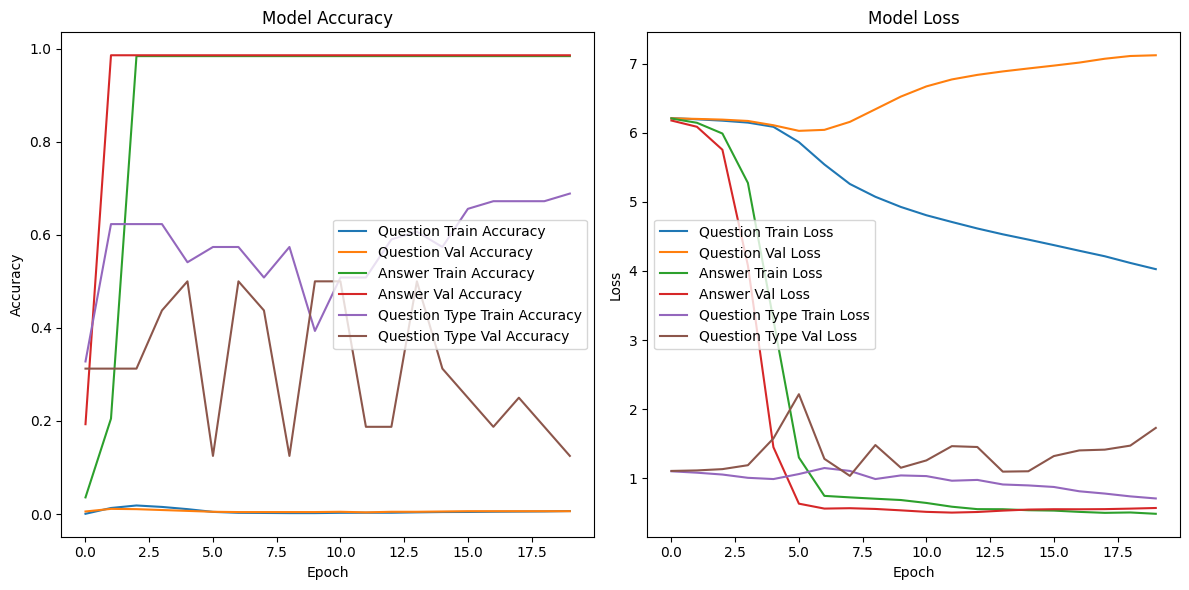

In [168]:

# data epoch

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(data_model.history['question_output_accuracy'], label='Question Train Accuracy')
plt.plot(data_model.history['val_question_output_accuracy'], label='Question Val Accuracy')
plt.plot(data_model.history['answer_output_accuracy'], label='Answer Train Accuracy')
plt.plot(data_model.history['val_answer_output_accuracy'], label='Answer Val Accuracy')
plt.plot(data_model.history['question_type_output_accuracy'], label='Question Type Train Accuracy')
plt.plot(data_model.history['val_question_type_output_accuracy'], label='Question Type Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data_model.history['question_output_loss'], label='Question Train Loss')
plt.plot(data_model.history['val_question_output_loss'], label='Question Val Loss')
plt.plot(data_model.history['answer_output_loss'], label='Answer Train Loss')
plt.plot(data_model.history['val_answer_output_loss'], label='Answer Val Loss')
plt.plot(data_model.history['question_type_output_loss'], label='Question Type Train Loss')
plt.plot(data_model.history['val_question_type_output_loss'], label='Question Type Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:



def sequence_to_text(sequence, tokenizer):
    """ Converts a tokenized sequence back into readable text. """
    return " ".join([tokenizer.index_word.get(idx, "<OOV>") for idx in sequence if idx != 0])

print("\n=== Evaluation on Test Data ===")
pred_question_test, pred_answer_test, pred_qtype_test = model.predict([context_test, question_test])
pred_qtype_labels_test = np.argmax(pred_qtype_test, axis=1)

print("Classification Report for Question Type (Test Set):")
print(classification_report(qtype_test, pred_qtype_labels_test))
print("Test Accuracy:", accuracy_score(qtype_test, pred_qtype_labels_test))
print("Test Precision:", precision_score(qtype_test, pred_qtype_labels_test, average='weighted'))
print("Test Recall:", recall_score(qtype_test, pred_qtype_labels_test, average='weighted'))

reference_question_test = [sequence_to_text(question_test[0], tokenizer)]
candidate_question_test = sequence_to_text(np.argmax(pred_question_test[0], axis=-1), tokenizer)
bleu_score_question_test = nltk.translate.bleu_score.sentence_bleu(reference_question_test, candidate_question_test)
print("BLEU Score for first test sample (question generation):", bleu_score_question_test)

reference_answer_test = [sequence_to_text(answer_test[0], tokenizer)]
candidate_answer_test = sequence_to_text(np.argmax(pred_answer_test[0], axis=-1), tokenizer)
bleu_score_answer_test = nltk.translate.bleu_score.sentence_bleu(reference_answer_test, candidate_answer_test)
print("BLEU Score for first test sample (answer generation):", bleu_score_answer_test)

print("\n=== Evaluation on Validation Data ===")
pred_question_val, pred_answer_val, pred_qtype_val = model.predict([context_val, question_val])
pred_qtype_labels_val = np.argmax(pred_qtype_val, axis=1)

print("Classification Report for Question Type (Validation Set):")
print(classification_report(qtype_val, pred_qtype_labels_val))
print("Validation Accuracy:", accuracy_score(qtype_val, pred_qtype_labels_val))
print("Validation Precision:", precision_score(qtype_val, pred_qtype_labels_val, average='weighted'))
print("Validation Recall:", recall_score(qtype_val, pred_qtype_labels_val, average='weighted'))

reference_question_val = [sequence_to_text(question_val[0], tokenizer)]
candidate_question_val = sequence_to_text(np.argmax(pred_question_val[0], axis=-1), tokenizer)
bleu_score_question_val = nltk.translate.bleu_score.sentence_bleu(reference_question_val, candidate_question_val)
print("BLEU Score for first validation sample (question generation):", bleu_score_question_val)

reference_answer_val = [sequence_to_text(answer_val[0], tokenizer)]
candidate_answer_val = sequence_to_text(np.argmax(pred_answer_val[0], axis=-1), tokenizer)
bleu_score_answer_val = nltk.translate.bleu_score.sentence_bleu(reference_answer_val, candidate_answer_val)
print("BLEU Score for first validation sample (answer generation):", bleu_score_answer_val)



=== Evaluation on Test Data ===
